In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
import model.sdes as sdes
import model.discrete_diffusers as discrete_diffusers
from plot.plot import plot_mnist_digits
import torch
import torchvision
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import os
import tqdm.notebook

In [2]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define the branches and create the data loader

In [3]:
samples_per_digit = 100
dataset = torchvision.datasets.MNIST(
    "/gstore/data/resbioai/tsenga5/datasets", train=True, transform=(lambda img: (np.asarray(img)[None] / 256 * 2) - 1)
)

classes = torch.unique(dataset.targets).cpu().numpy()
digits_by_class = {}
for c in classes:
    mask = dataset.targets == c
    digits = (dataset.data[mask] / 256 * 2) - 1
    sample_inds = torch.tensor(np.random.choice(len(digits), size=samples_per_digit, replace=False))
    digits_by_class[c] = digits[sample_inds][:, None].to(DEVICE)
input_shape = (1, 28, 28)

In [4]:
# Create the diffusers
cont_diffuser = sdes.VariancePreservingSDE(0.1, 20, input_shape)
disc_diffuser = discrete_diffusers.GaussianDiffuser(1e-4, 1e-5, input_shape)

cont_t_limit = 1
disc_t_limit = 1000

### Show the forward-diffusion process

In [5]:
def run_forward_diffusion(digits_by_class, diffuser, times):
    """
    Runs the forward diffusion process over many time points and
    saves the result for each digit class.
    Arguments:
        `digits_by_class`: dictionary mapping class to B x 1 x 28 x 28
            tensors
        `diffuser`: instantiated diffuser object
        `times`: array of times to perform diffusion at, length T
    Returns a dictionary mapping class to T x B x 1 x 28 x 28 tensors.
    """
    diffused_digits_by_class = {}
    for c, x0 in digits_by_class.items():
        print("Forward-diffusing class %s" % c)
        result = torch.empty((len(times),) + x0.shape, device=DEVICE)
        for t_i, t in enumerate(times):
            xt, score = diffuser.forward(x0, torch.full(x0.shape[:1], t).to(DEVICE))
            result[t_i] = xt
        diffused_digits_by_class[c] = result
        
    # Plot some results over time
    inds_to_show = np.arange(0, len(times), len(times) // 15)
    inds_to_show = np.concatenate([inds_to_show, [len(times) - 1]])
    num_classes = len(digits_by_class)
    num_show_per_class = 3
    for t_i in inds_to_show:
        t = times[t_i]
        digits_to_show = np.empty((num_classes * num_show_per_class,) + result.shape[2:])
        
        for c_i, c in enumerate(sorted(digits_by_class.keys())):
            # Sample digits
            inds = np.random.choice(len(digits_by_class[c]), size=num_show_per_class, replace=False)
            digits_to_show[c_i * num_show_per_class : (c_i + 1) * num_show_per_class] = \
                diffused_digits_by_class[c][t_i][inds].cpu().numpy()

        # Reshape:
        digits_to_show = digits_to_show.reshape(
            (num_classes, num_show_per_class) + digits_to_show.shape[1:]
        )
        digits_to_show = np.swapaxes(digits_to_show, 0, 1).reshape((-1,) + digits_to_show.shape[2:])
            
        plot_mnist_digits(digits_to_show, grid_size=(num_classes, num_show_per_class), title=("t = %.2f" % t))

    # Show distribution over time
    fig, ax = plt.subplots(figsize=(20, 8))
    bins = np.linspace(-4, 4, 1000)
    cmap = plt.get_cmap("magma")
    for t_i in tqdm.notebook.trange(len(times)):
        all_vals = np.concatenate([
            np.random.choice(np.ravel(digits[t_i].cpu().numpy()), size=100, replace=False)
            for digits in diffused_digits_by_class.values()
        ])
        ax.hist(all_vals, bins=bins, histtype="step", color=cmap(t_i / len(times)), alpha=0.5, density=True)
    prior = diffuser.sample_prior(len(x0), torch.ones(len(x0)).to(DEVICE) * times[-1]).cpu().numpy()
    ax.hist(np.ravel(prior), bins=bins, histtype="step", color="blue", linewidth=2, density=True, label="Sampled prior")
    ax.set_xlabel("x")
    ax.set_ylabel("p(x)")
    ax.set_title("Evolution of p(x) over forward SDE")
    ax.set_ylim((0, 3))
    plt.legend()
    plt.show()
    
    return diffused_digits_by_class

In [6]:
def compute_time_similarities(diffused_digits_by_class, times):
    """
    Given the output of `run_forward_diffusion`, computes the average
    similarity between classes at each time point.
    Arguments:
        `diffused_digits_by_class`: dictionary mapping class to
            T x B x 1 x 28 x 28 tensors
        `times`: T-array of times at which diffusion was performed
    Returns a T x C x C array of similarities between classes at each
    time, and a list of classes C parallel to the ordering in the similarity
    matrix.
    """
    classes = list(sorted(diffused_digits_by_class.keys()))
    sim_matrix = np.empty((len(times), len(classes), len(classes)))
    for t_i in tqdm.notebook.trange(len(times)):
        for i in range(len(classes)):
            for j in range(i + 1):
                digits_1 = torch.flatten(diffused_digits_by_class[classes[i]][t_i], start_dim=1)
                digits_2 = torch.flatten(diffused_digits_by_class[classes[j]][t_i], start_dim=1)
                
                if i == j:
                    # Flip so we always compare different objects
                    digits_2 = torch.flip(digits_2, dims=(0,))
                    if len(digits_2) % 2 == 1:
                        mid = len(digits_2) // 2
                        temp = digits_2[mid]
                        digits_2[mid] = digits_2[0]
                        digits_2[0] = temp
                
                sims = torch.nn.functional.cosine_similarity(digits_1, digits_2, dim=1)
                sim = torch.mean(sims).item()
                sim_matrix[t_i, i, j] = sim
                sim_matrix[t_i, j, i] = sim
                
    # Plot initial pairwise similarities
    labels = np.array(["%s-%s" % (classes[i], classes[j]) for i in range(len(classes)) for j in range(i + 1)])
    sims = np.array([sim_matrix[0, i, j] for i in range(len(classes)) for j in range(i + 1)])
    inds = np.flip(np.argsort(sims))
    labels, sims = labels[inds], sims[inds]
    fig, ax = plt.subplots(figsize=(20, 4))
    ax.bar(labels, sims)
    ax.set_ylabel("Average similarity")
    ax.set_title("Average similarity between pairs of classes (t = 0)")
    plt.show()
                
    # Plot average similarity over time
    mean_sims = []
    triu_inds = np.triu_indices(len(classes))
    for t_i in range(len(sim_matrix)):
        mean_sims.append(np.mean(sim_matrix[t_i][triu_inds]))
    fig, ax = plt.subplots(figsize=(20, 4))
    ax.plot(mean_sims)
    ax.set_xlabel("t")
    ax.set_ylabel("Average similarity")
    ax.set_title("Average similarity over all classes during forward diffusion")
    plt.show()
    
    return sim_matrix, classes

In [7]:
def compute_branch_points(time_sim_matrix, times, sim_matrix_classes, epsilon=0.005):
    """
    Given the output of `compute_time_similarities`, computes the proper
    branch points for the digit classes in a tree structure.
    Arguments:
        `time_sim_matrix`: T x C x C matrix of which 
        `times`: T-array of times
        `sim_matrix_classes`: list of C classes in the same order as in
            `time_sim_matrix`
        `epsilon`: error boundary for comparing similarities
    Returns a list of branch points, where each branch point is a
    tuple of a time, and tuples of the classes which diverge at that
    branch point.
    """
    assert np.all(np.diff(times) > 0)
    
    # Smooth the similarity trajectories over time
    for i in range(time_sim_matrix.shape[1]):
        for j in range(i + 1):
            time_sim_matrix[:, i, j] = scipy.ndimage.gaussian_filter(time_sim_matrix[:, i, j], sigma=3)
            if i != j:
                time_sim_matrix[:, j, i] = time_sim_matrix[:, i, j]
    
    # For each distinct pair of classes, get the first (earliest) time
    # that the average similarity is about the same as the average similarity
    # within the classes
    crossover_times = np.zeros(time_sim_matrix.shape[1:])
    for i in range(time_sim_matrix.shape[1]):
        for j in range(i):
            intra_sim = (time_sim_matrix[:, i, i] + time_sim_matrix[:, j, j]) / 2
            inter_sim = time_sim_matrix[:, i, j]
            crossed = np.where(inter_sim >= intra_sim - epsilon)[0]
            if not crossed.size:
                raise ValueError("Index %d and %d intersimilarity did not cross intrasimilarity" % (i, j))
            crossover_time = times[np.min(crossed)]
            crossover_times[i, j] = crossover_time
            crossover_times[j, i] = crossover_time
            
    # Compute the branch points using disjoint sets
    # From the earliest crossover time to the latest, iteratively
    # merge classes until all classes are in the same set
    def union(ds_arr, ds_sets, root_1, root_2):
        if ds_arr[root_1] < ds_arr[root_2]:
            # root_2 is larger
            ds_arr[root_2] += ds_arr[root_1]  # Update size
            ds_arr[root_1] = root_2  # root_2 is parent of root_1
            ds_sets[root_2] = ds_sets[root_1] | ds_sets[root_2]
            ds_sets[root_1] = None
        else:
            # root_1 is larger or equal
            ds_arr[root_1] += ds_arr[root_2]  # Update size
            ds_arr[root_2] = root_1  # root_1 is parent of root_2
            ds_sets[root_1] = ds_sets[root_1] | ds_sets[root_2]
            ds_sets[root_2] = None
    
    def find(ds_arr, x):
        if ds_arr[x] < 0:
            # x is root
            return x
        else:
            # Find root of x's parent and set x's parent to be that root
            ds_arr[x] = find(ds_arr, ds_arr[x])
            return ds_arr[x]
    
    sorted_inds = np.stack(
        np.unravel_index(np.argsort(np.ravel(crossover_times)), crossover_times.shape),
        axis=1
    )
    ds_arr = np.full(time_sim_matrix.shape[1], -1)
    ds_sets = [set([sim_matrix_classes[i]]) for i in range(len(ds_arr))]
    branch_points = []
    for i, j in sorted_inds:
        if i == j:
            continue
        
        # If i and j are in the same set, move on
        root_i, root_j = find(ds_arr, i), find(ds_arr, j)
        if root_i == root_j:
            continue
        
        # Otherwise, merge together the sets containing i and j
        branch_points.append((
            crossover_times[i, j], tuple(sorted(ds_sets[root_i])), tuple(sorted(ds_sets[root_j]))
        ))
        union(ds_arr, ds_sets, root_i, root_j)
        
        # If all classes are in the same set, stop
        if np.sum(ds_arr < 0) == 1:
            break
    
    return branch_points

In [8]:
def branch_points_to_branch_defs(branch_points, t_limit, t_start=0):
    """
    Converts a set of branch points to a different format of
    branch definitions.
    Arguments:
        `branch_points`: the output of `compute_branch_points`
        `t_limit`: final time point
        `t_start`: initial time point
    Returns a list of branch definitions, where each definition
    is a tuple of: the tuple of classes in that branch, the start
    time, and the end time.
    """
    assert np.all(np.diff([bp[0] for bp in branch_points]) >= 0)
    # Branch points are sorted by time, so last point has all classes
    all_classes = tuple(sorted(branch_points[-1][1] + branch_points[-1][2]))
    current_branch_ends = [(t_limit, all_classes)]
    
    branch_defs = []
    for bp in branch_points[::-1]:
        # In reverse order, iterate through branch points
        # Figure out which of the current branch ends it splits
        split_time = bp[0]
        classes = tuple(sorted(bp[1] + bp[2]))
        be_i = [i for i, be in enumerate(current_branch_ends) if classes == be[1]]
        if len(be_i) != 1:
            raise ValueError("Found %d branch ends matching classes %s" % (len(be_i), classes))
        be_i = be_i[0]
        
        # The branch it splits is now over, and can be added to branch_defs
        be = current_branch_ends.pop(be_i)  # Remove it from the current set
        branch_defs.append((be[1], bp[0], be[0]))
        
        # The branch point introduces two new branch ends with the same end time
        current_branch_ends.extend([(bp[0], bp[1]), (bp[0], bp[2])])
    
    # The remaining branch ends all have branch starts which are t_start
    for be in current_branch_ends:
        branch_defs.append((be[1], t_start, be[0]))
    
    return branch_defs

Forward-diffusing class 0
Forward-diffusing class 1
Forward-diffusing class 2
Forward-diffusing class 3
Forward-diffusing class 4
Forward-diffusing class 5
Forward-diffusing class 6
Forward-diffusing class 7
Forward-diffusing class 8
Forward-diffusing class 9


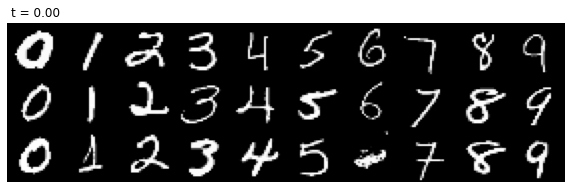

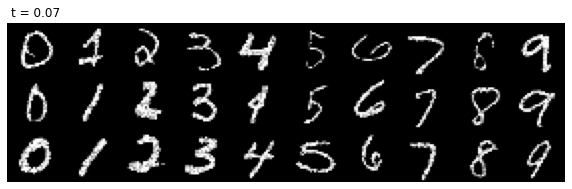

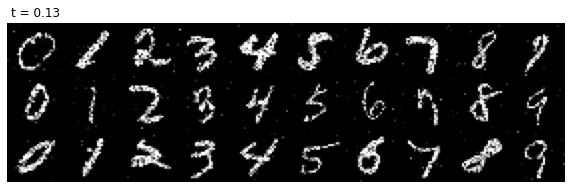

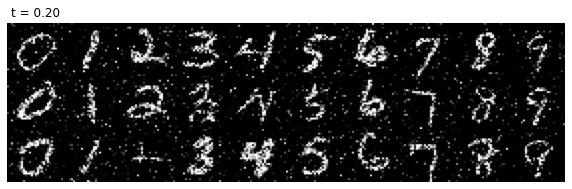

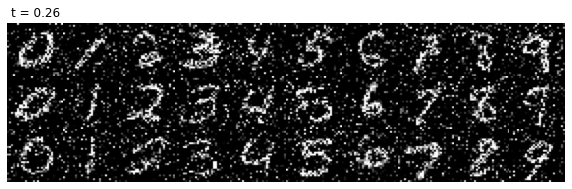

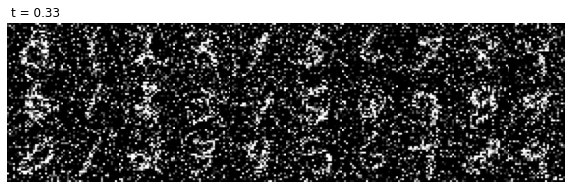

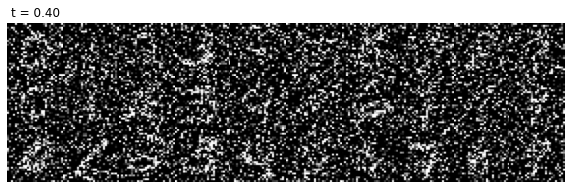

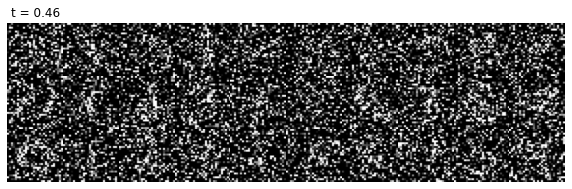

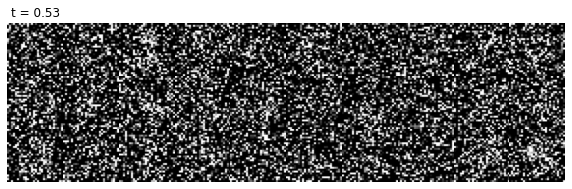

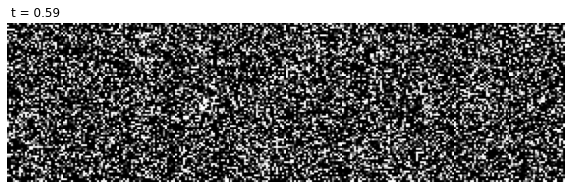

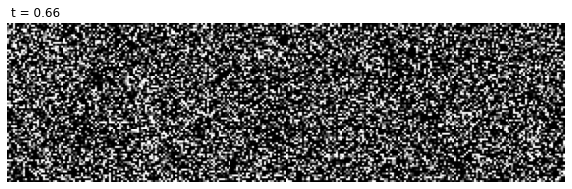

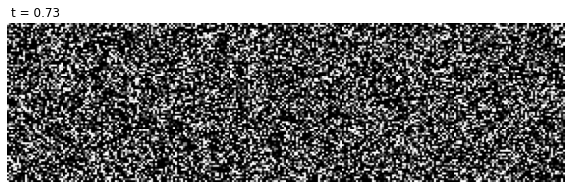

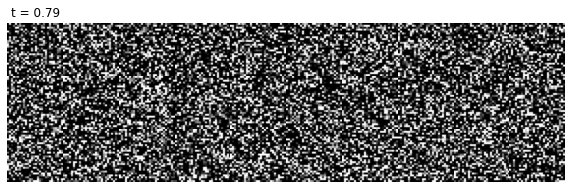

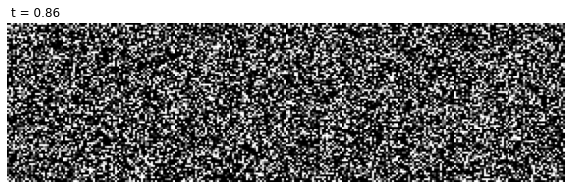

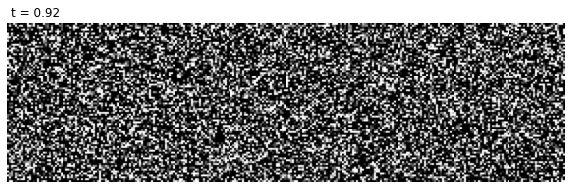

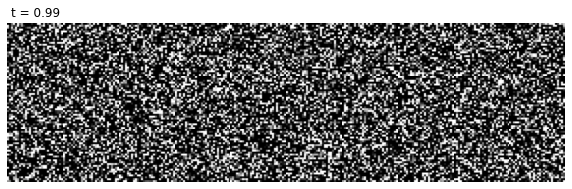

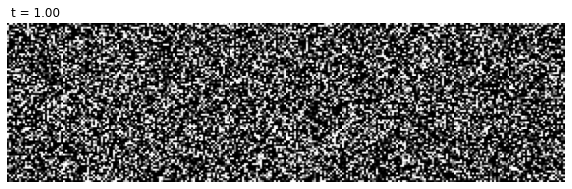

  0%|          | 0/1000 [00:00<?, ?it/s]

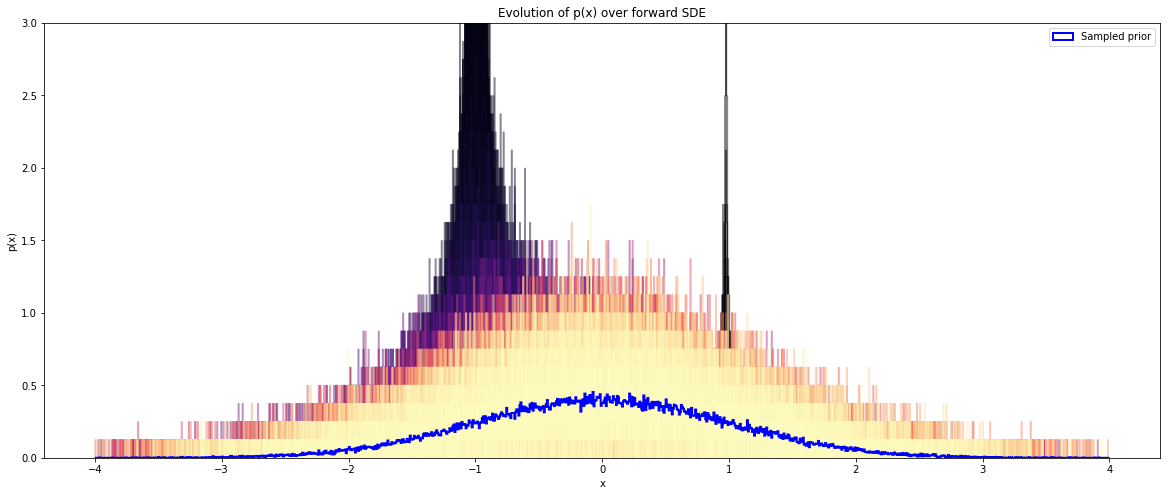

  0%|          | 0/1000 [00:00<?, ?it/s]

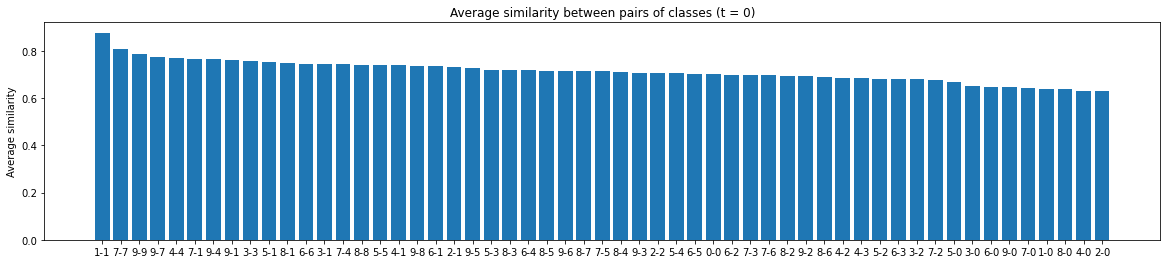

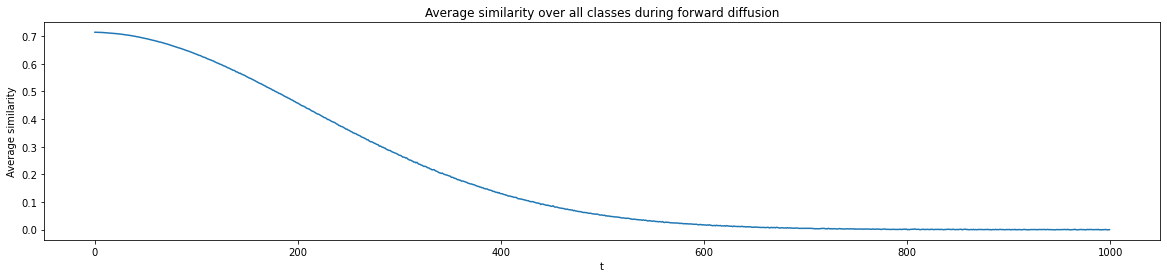

[(0.2822822822822823, (4,), (9,)), (0.36536536536536535, (4, 9), (7,)), (0.3763763763763764, (5,), (3,)), (0.3763763763763764, (8,), (3, 5)), (0.3843843843843844, (3, 5, 8), (4, 7, 9)), (0.3993993993993994, (2,), (3, 4, 5, 7, 8, 9)), (0.3993993993993994, (6,), (2, 3, 4, 5, 7, 8, 9)), (0.4574574574574575, (1,), (2, 3, 4, 5, 6, 7, 8, 9)), (0.45845845845845845, (1, 2, 3, 4, 5, 6, 7, 8, 9), (0,))]

[((0, 1, 2, 3, 4, 5, 6, 7, 8, 9), 0.45845845845845845, 1), ((1, 2, 3, 4, 5, 6, 7, 8, 9), 0.4574574574574575, 0.45845845845845845), ((2, 3, 4, 5, 6, 7, 8, 9), 0.3993993993993994, 0.4574574574574575), ((2, 3, 4, 5, 7, 8, 9), 0.3993993993993994, 0.3993993993993994), ((3, 4, 5, 7, 8, 9), 0.3843843843843844, 0.3993993993993994), ((3, 5, 8), 0.3763763763763764, 0.3843843843843844), ((3, 5), 0.3763763763763764, 0.3763763763763764), ((4, 7, 9), 0.36536536536536535, 0.3843843843843844), ((4, 9), 0.2822822822822823, 0.36536536536536535), ((0,), 0, 0.45845845845845845), ((1,), 0, 0.4574574574574575), ((6,)

In [9]:
diffuser, t_limit = cont_diffuser, cont_t_limit

times = np.linspace(0, t_limit, 1000)
diffused_digits_by_class = run_forward_diffusion(
    digits_by_class, diffuser, times
)
sim_matrix, sim_matrix_classes = compute_time_similarities(diffused_digits_by_class, times)
branch_points = compute_branch_points(sim_matrix, times, sim_matrix_classes, epsilon=0.005)
branch_defs = branch_points_to_branch_defs(branch_points, t_limit)
print(branch_points)
print()
print(branch_defs)

Forward-diffusing class 0
Forward-diffusing class 1
Forward-diffusing class 2
Forward-diffusing class 3
Forward-diffusing class 4
Forward-diffusing class 5
Forward-diffusing class 6
Forward-diffusing class 7
Forward-diffusing class 8
Forward-diffusing class 9


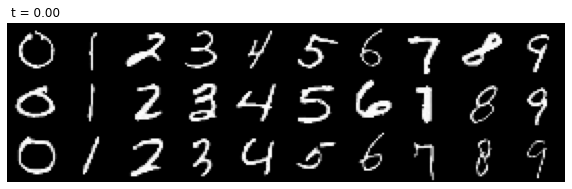

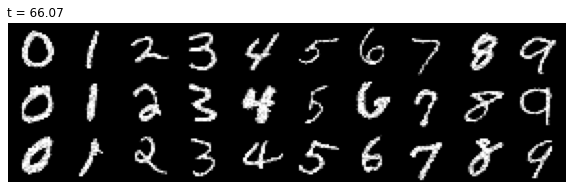

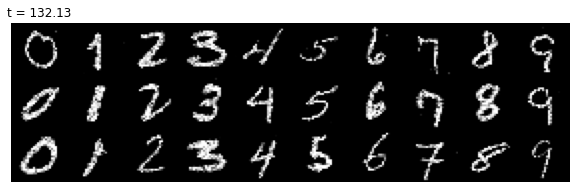

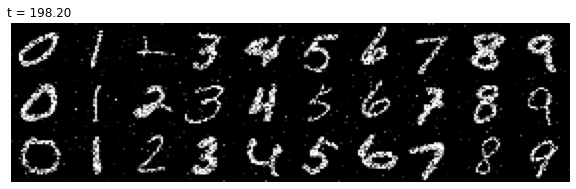

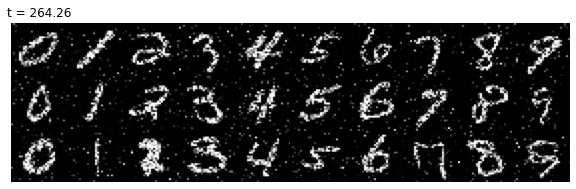

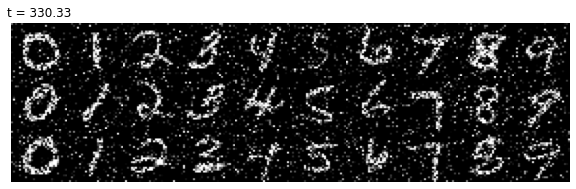

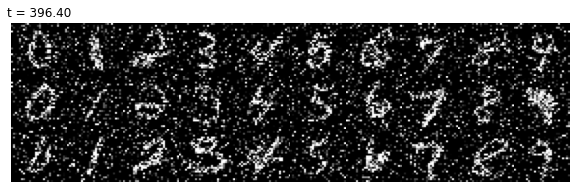

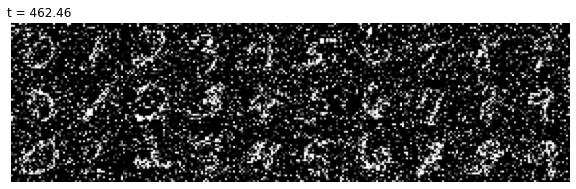

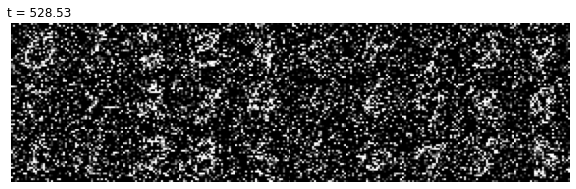

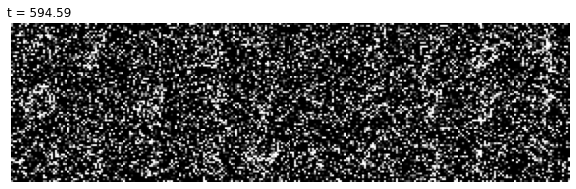

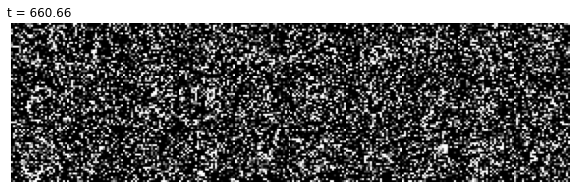

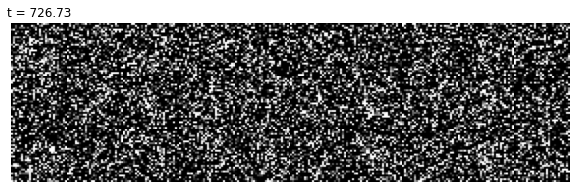

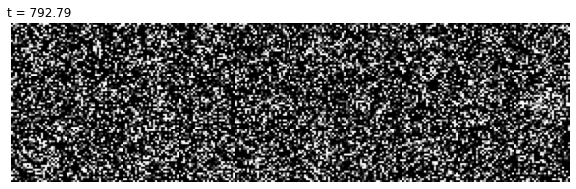

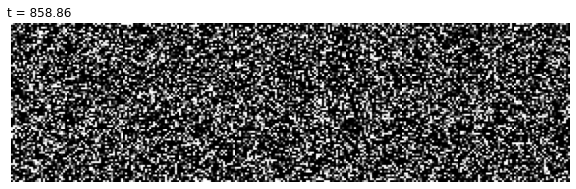

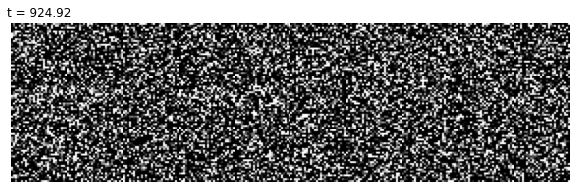

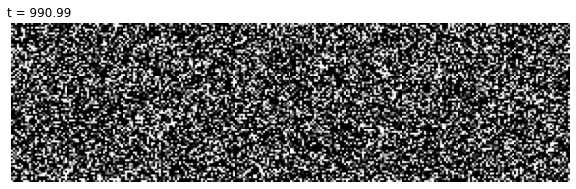

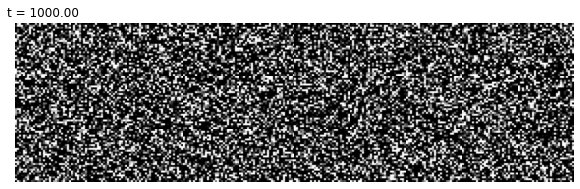

  0%|          | 0/1000 [00:00<?, ?it/s]

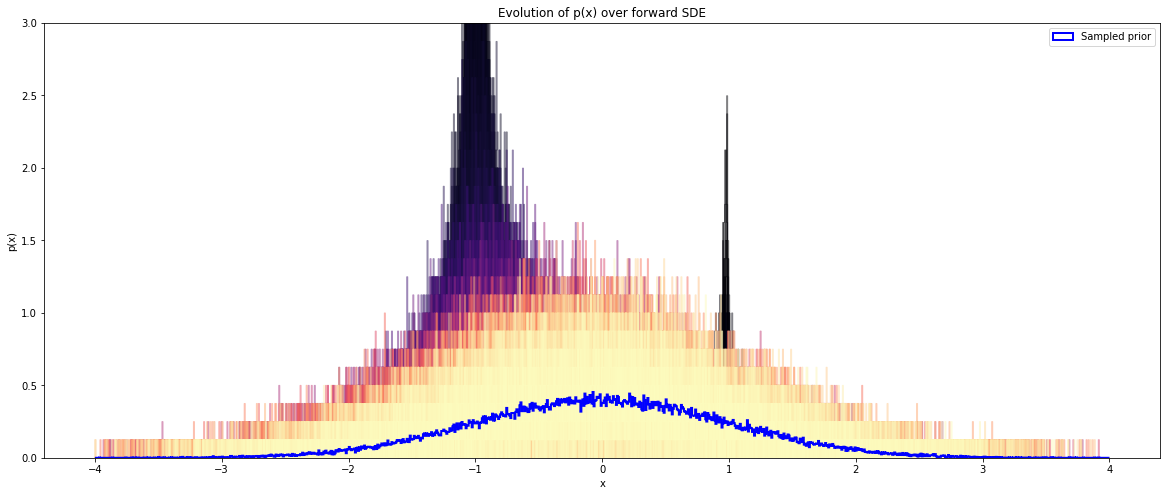

  0%|          | 0/1000 [00:00<?, ?it/s]

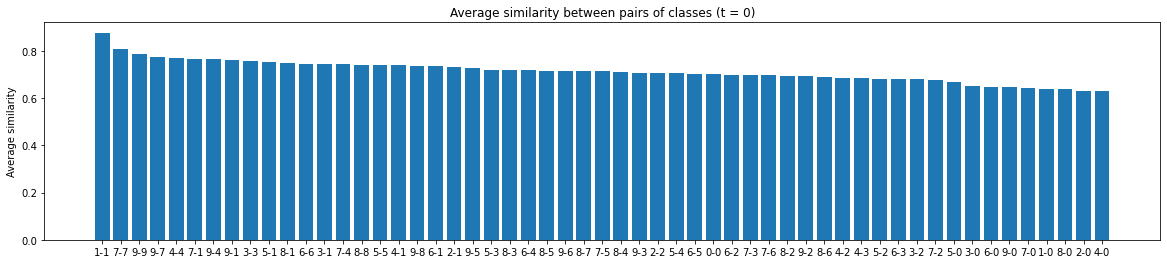

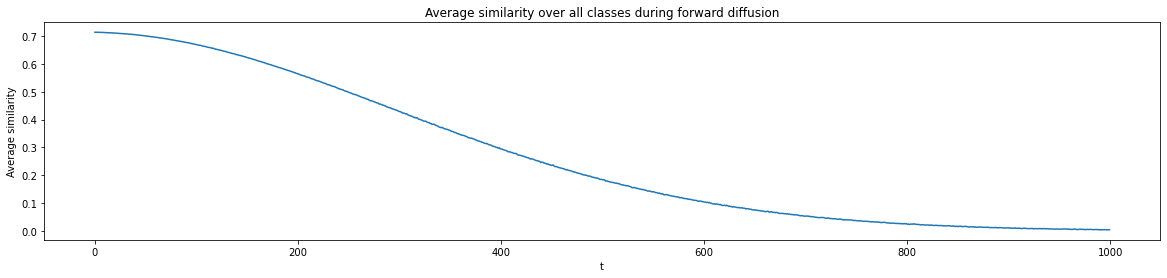

[(593.5935935935936, (4,), (9,)), (595.5955955955957, (4, 9), (7,)), (627.6276276276277, (5,), (3,)), (628.6286286286287, (4, 7, 9), (8,)), (628.6286286286287, (3, 5), (4, 7, 8, 9)), (629.6296296296297, (3, 4, 5, 7, 8, 9), (2,)), (647.6476476476477, (6,), (2, 3, 4, 5, 7, 8, 9)), (714.7147147147148, (1,), (2, 3, 4, 5, 6, 7, 8, 9)), (718.7187187187188, (0,), (1, 2, 3, 4, 5, 6, 7, 8, 9))]

[((0, 1, 2, 3, 4, 5, 6, 7, 8, 9), 719, 1000), ((1, 2, 3, 4, 5, 6, 7, 8, 9), 715, 719), ((2, 3, 4, 5, 6, 7, 8, 9), 648, 715), ((2, 3, 4, 5, 7, 8, 9), 630, 648), ((3, 4, 5, 7, 8, 9), 629, 630), ((4, 7, 8, 9), 629, 629), ((3, 5), 628, 629), ((4, 7, 9), 596, 629), ((4, 9), 594, 596), ((0,), 0, 719), ((1,), 0, 715), ((6,), 0, 648), ((2,), 0, 630), ((8,), 0, 629), ((5,), 0, 628), ((3,), 0, 628), ((7,), 0, 596), ((4,), 0, 594), ((9,), 0, 594)]


In [10]:
diffuser, t_limit = disc_diffuser, disc_t_limit

times = np.linspace(0, t_limit, 1000)
diffused_digits_by_class = run_forward_diffusion(
    digits_by_class, diffuser, times
)
sim_matrix, sim_matrix_classes = compute_time_similarities(diffused_digits_by_class, times)
branch_points = compute_branch_points(sim_matrix, times, sim_matrix_classes, epsilon=0.001)
branch_defs = branch_points_to_branch_defs(branch_points, t_limit)
branch_defs = [(t[0], round(t[1]), round(t[2])) for t in branch_defs]  # Round to integers
print(branch_points)
print()
print(branch_defs)